In [2]:
%matplotlib notebook
import pylab as plt, numpy as np
import pyuvdata, uvtools, hera_cal, aipy
import time
import linsolve
import healpy
from matplotlib import cm
import pickle
import pylab

In [3]:
antennas = [80, 104, 96, 64, 53, 31, 65, 88, 9, 20, 89, 43, 105, 22, 81, 10, 72, 112, 97]
antpos_top = np.array([[-25.28794179, -14.6, 0.0], [-25.28794179, 0.0, 0.0], [-25.28794179, 14.6, 0.0], [-12.6439709, -21.9,   0.0],
                      [ -12.6439709, -7.3, 0.0], [ -12.6439709, 7.3,0.0], [-12.6439709, 21.9,  0.0], [0.0, -29.2,   0.0],
                      [ 0.0, -14.6,   0.0], [0.0, 0.0, 0.0], [ 0.0, 14.6, 0.0], [ 0.0, 29.2,  0.0], [12.6439709, -21.9,  0.0],
                      [12.6439709, -7.3,  0.0], [ 12.6439709, 7.3, 0.0], [ 12.6439709,  21.9, 0.0], [25.28794179, -14.6,  0.0], [ 25.28794179, 0.0, 0.0],
                      [25.28794179, 14.6,  0.0]])

In [4]:
freqs = np.linspace(100,200,1024)
aa = aipy.cal.get_aa('hsa7458_v001', freqs)
eq2top = aipy.coord.eq2top_m(0., aa.lat)
top2eq = aipy.coord.top2eq_m(0, aa.lat)
antpos_eq = np.dot(top2eq, antpos_top.T).T
print antpos_eq.shape
reds = hera_cal.redcal.get_reds({i:ai for i,ai in enumerate(antpos_top)})
uniq_bls = [red[0] for red in reds]
print uniq_bls, len(uniq_bls)

(19, 3)
[(0, 3, 'XX'), (0, 4, 'XX'), (0, 1, 'XX'), (0, 8, 'XX'), (1, 3, 'XX'), (0, 5, 'XX'), (0, 2, 'XX'), (0, 7, 'XX'), (0, 9, 'XX'), (2, 3, 'XX'), (0, 6, 'XX'), (1, 7, 'XX'), (0, 10, 'XX'), (0, 12, 'XX'), (0, 13, 'XX'), (1, 12, 'XX'), (0, 14, 'XX'), (3, 6, 'XX'), (2, 7, 'XX'), (0, 11, 'XX'), (0, 16, 'XX'), (2, 12, 'XX'), (0, 15, 'XX'), (6, 7, 'XX'), (3, 11, 'XX'), (1, 16, 'XX'), (0, 17, 'XX'), (7, 11, 'XX'), (2, 16, 'XX'), (0, 18, 'XX')] 30


In [49]:
def v_cpu(antpos, freq, eq2tops, crd_eq, I_sky, 
            real_dtype=np.float32, complex_dtype=np.complex64,
            verbose=False):
    nant = len(antpos)
    ntimes = len(eq2tops)
    npix = 10#I_sky.size
    Isqrt = np.sqrt(I_sky).astype(real_dtype)
    antpos = antpos.astype(real_dtype)
    A_s = np.empty((nant,npix), dtype=real_dtype)
    vis = np.empty((ntimes,nant,nant), dtype=complex_dtype)
    tau = np.empty((nant,npix), dtype=real_dtype)
    v = np.empty((nant,npix), dtype=complex_dtype)
    for t,eq2top in enumerate(eq2tops.astype(real_dtype)):
        if verbose:
            print '%d/%d' % (t, ntimes)
            t_start = time.time()
        tx,ty,tz = crd_top = np.dot(eq2top, crd_eq)
        A_s = np.where(tz > 0, 1, 0)
        print antpos.shape, crd_top.shape
        np.dot(antpos, crd_top, out=tau)
        np.exp((1j*freq)*tau, out=v)
        AI_s = A_s * Isqrt
        v *= AI_s
        if verbose:
            print 'TOTAL:', time.time() - t_start
            #print vis[t].conj()
        yield crd_top, v
    return

def aa_to_eq2tops(aa, jds):
    eq2tops = np.empty((len(jds),3,3), dtype=np.float32)
    for i,jd in enumerate(jds):
        aa.set_jultime(jd)
        eq2tops[i] = aa.eq2top_m
    return eq2tops

def hmap_to_crd_eq(h):
    px = np.arange(h.npix())
    crd_eq = np.array(h.px2crd(px,3), dtype=np.float32)
    return crd_eq

def hmap_to_I(h):
    return h[np.arange(h.npix())].astype(np.float32)

In [73]:
jds = []
for i in range(100):
    jds.append(2458115.36413 + (i*3)/60./24.)
h = aipy.healpix.HealpixMap(nside=32)
#h.map = np.zeros((12*32**2))
h.map = np.random.normal(size=h.npix(), scale=1.) + 10
I_sky = hmap_to_I(h)
crd_eq = hmap_to_crd_eq(h)
print crd_eq.shape
eq2tops = aa_to_eq2tops(aa, jds)
#h.map[2000:2010] = 500
print eq2tops.shape

(3, 12288)
(100, 3, 3)


In [79]:
eq2top = aa_to_eq2tops(aa, jds[0:1])
print eq2top.shape
crds= np.dot(eq2top, crd_eq)
print crds[0,:,2000]

(1, 3, 3)
[-0.28677988  0.92457116  0.25084955]


In [80]:
eq2top = aa_to_eq2tops(aa, jds[0:1])
print eq2top.shape
crds= np.dot(eq2top, crd_eq[:,2000])
print crds

(1, 3, 3)
[[-0.28677988  0.92457116  0.25084955]]


<IPython.core.display.Javascript object>


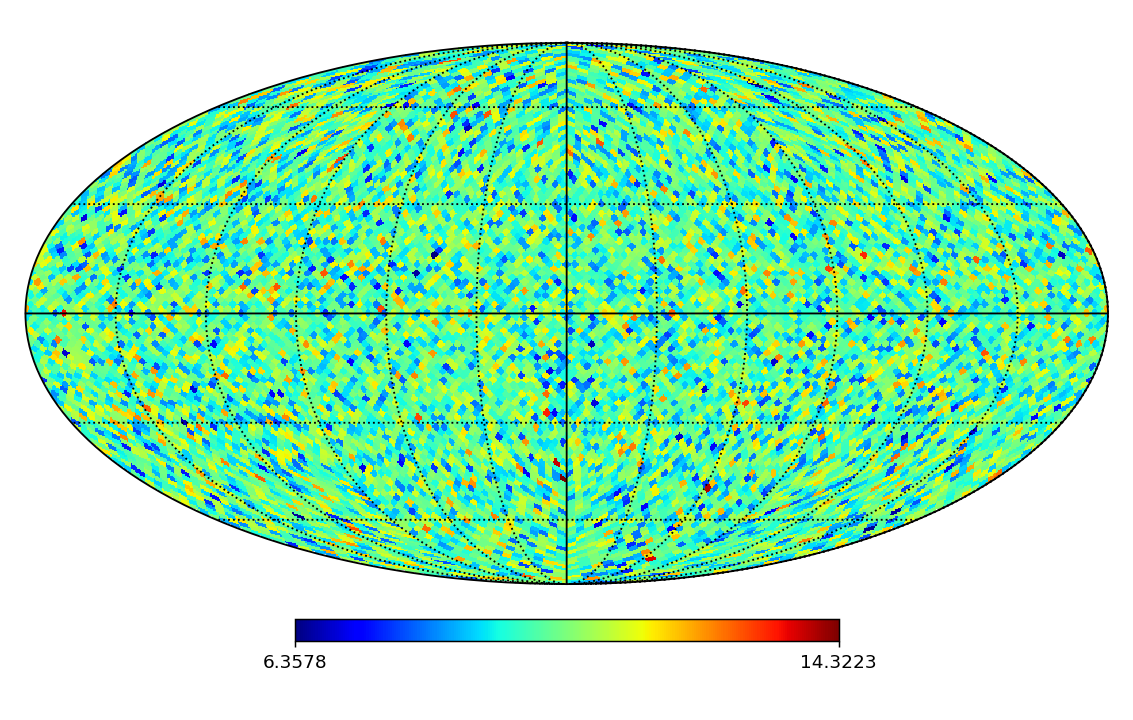

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [43]:
cmap = cm.jet
cmap.set_under('w')
healpy.mollview(h.map, title='', cmap=cmap)
healpy.graticule()

<IPython.core.display.Javascript object>


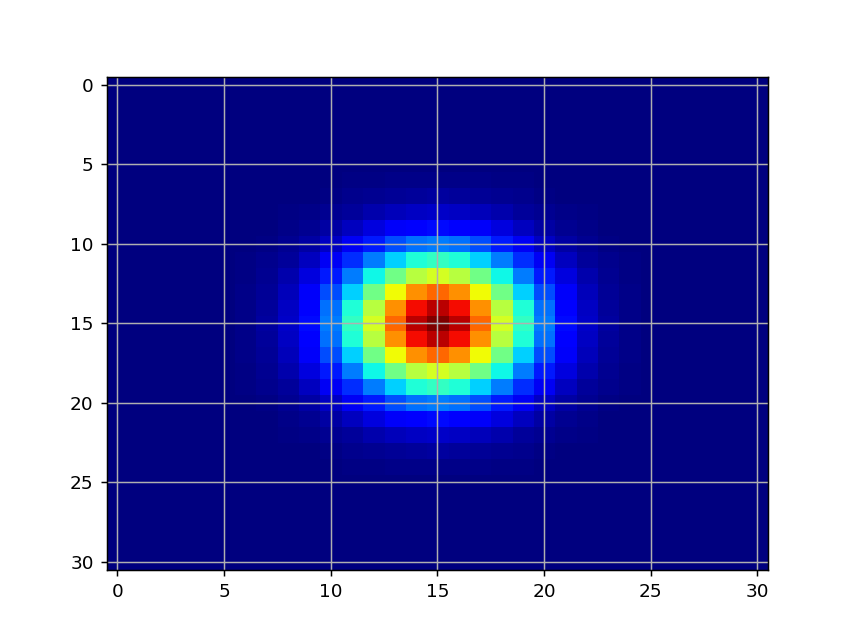

In [24]:
CH = 50
bm_pix = 31
bm_true = np.zeros((bm_pix,bm_pix), dtype=np.float)
bmx,bmy = np.indices(bm_true.shape)
bm_true = np.exp(-((bmx-15.)**2 + (bmy-15.)**2)/(2*3**2))

plt.imshow(bm_true, aspect='auto', cmap='jet')
plt.grid()

In [117]:
nant = len(antpos_eq)
print nant, bm_pix
consts = {}
eqs = {}

def mk_key(px,i,j,t):
    return 'w%d_a%d_a%d_t%d' % (px,i,j,t)

for t, (crd_top,v) in enumerate(v_cpu(antpos_eq, freqs[CH], eq2tops[0:1], crd_eq[:,2000:2010], I_sky[2000:2010], verbose=True)):
#for t,(crd_top,v) in enumerate(v_cpu(antpos, freqs[CH], eq2tops[:1], crd_eq, I_sky, verbose=True)):
    tx,ty,tz = crd_top
    x,y = (bm_pix-1) * (.5*tx+.5), (bm_pix-1) * (.5*ty+.5)
    px0,py0 = np.floor(x).astype(np.int), np.floor(y).astype(np.int)
    px1,py1 = np.clip(px0+1,0,bm_pix-1), np.clip(py0+1,0,bm_pix-1)
    fx,fy = x-px0, y-py0
    x0y0 = np.array([px0, py0], dtype=np.int)
    wx0y0 = (1-fx) * (1-fy)
    x0y1 = np.array([px0, py1], dtype=np.int)
    wx0y1 = (1-fx) * fy
    x1y0 = np.array([px1, py0], dtype=np.int)
    wx1y0 = fx * (1-fy)
    x1y1 = np.array([px1, py1], dtype=np.int)
    wx1y1 = fx * fy
    A_s = bm_true[px0,py0] * wx0y0 + bm_true[px0,py1] * wx0y1 + \
          bm_true[px1,py0] * wx1y0 + bm_true[px1,py1] * wx1y1 
    A_s.shape = (1,-1)
    Av = A_s * v
    xy = np.concatenate([x0y0, x0y1, x1y0, x1y1], axis=1)
    wxy = [wx0y0, wx0y1, wx1y0, wx1y1]
    #print xy[0], xy[1]
    for i,j,_ in uniq_bls:
        #print t, i,j
        vis_ij = v[i] * v[j].conj()
        hist = np.zeros((bm_pix,bm_pix), dtype=np.complex64)
        ws = np.concatenate([w * vis_ij for w in wxy], axis=0)
        print ws.shape
        hist.real,_,_ = np.histogram2d(xy[0], xy[1], weights=ws.real, range=((0,bm_pix),(0,bm_pix)), bins=bm_pix)
        hist.imag,_,_ = np.histogram2d(xy[0], xy[1], weights=ws.imag, range=((0,bm_pix),(0,bm_pix)), bins=bm_pix)
        c = {mk_key(px,i,j,t):w for px,w in enumerate(hist.flatten()) if np.abs(w) > 0}
        eq = ' + '.join([mk_key(px,i,j,t)+'*b%d' % (px) for px in xrange(hist.size) if c.has_key(mk_key(px,i,j,t))])
        #print 'eq:',eq
        eqs[eq] = np.dot(Av[i], Av[j].T.conj())
        #print t, i, j, eq, eqs[eq]
        consts.update(c)
       # print 'c:',c
print len(eqs), len(consts)

19 31
0/1
(19, 3) (3, 10)
TOTAL: 0.000244140625
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
(40,)
30 480


In [106]:
eqs

{'w338_a0_a1_t0*b338 + w339_a0_a1_t0*b339 + w369_a0_a1_t0*b369 + w370_a0_a1_t0*b370 + w371_a0_a1_t0*b371 + w400_a0_a1_t0*b400 + w401_a0_a1_t0*b401 + w402_a0_a1_t0*b402 + w432_a0_a1_t0*b432 + w433_a0_a1_t0*b433 + w463_a0_a1_t0*b463 + w464_a0_a1_t0*b464 + w494_a0_a1_t0*b494 + w495_a0_a1_t0*b495 + w525_a0_a1_t0*b525 + w526_a0_a1_t0*b526': (5.162052787408785e-09+4.333189788547258e-09j),
 'w338_a0_a3_t0*b338 + w339_a0_a3_t0*b339 + w369_a0_a3_t0*b369 + w370_a0_a3_t0*b370 + w371_a0_a3_t0*b371 + w400_a0_a3_t0*b400 + w401_a0_a3_t0*b401 + w402_a0_a3_t0*b402 + w432_a0_a3_t0*b432 + w433_a0_a3_t0*b433 + w463_a0_a3_t0*b463 + w464_a0_a3_t0*b464 + w494_a0_a3_t0*b494 + w495_a0_a3_t0*b495 + w525_a0_a3_t0*b525 + w526_a0_a3_t0*b526': (1.7328171210055055e-09+6.045284998283505e-09j),
 'w338_a0_a4_t0*b338 + w339_a0_a4_t0*b339 + w369_a0_a4_t0*b369 + w370_a0_a4_t0*b370 + w371_a0_a4_t0*b371 + w400_a0_a4_t0*b400 + w401_a0_a4_t0*b401 + w402_a0_a4_t0*b402 + w432_a0_a4_t0*b432 + w433_a0_a4_t0*b433 + w463_a0_a4_t0*b

In [107]:
p0 = [3,4,56]
p1 = [4,5,6]
p = [p0,p1]

In [108]:
len(p)

2

In [110]:
p[0][0]

3